# IVT (Invalid Traffic) Pattern Analysis

### Objective
To analyze ad-traffic data from multiple apps and identify patterns that explain why some apps were marked as IVT (Invalid Traffic) earlier, later, or not at all.

### Dataset Overview
- Source: Google Sheet with ad-traffic metrics  
- Key Columns: `unique_idfas`, `unique_ips`, `unique_uas`, `total_requests`, `impressions`, and derived ratios  
- Rows: Each represents hourly or daily aggregated traffic  
- Target Column: `IVT` (Invalid Traffic indicator)

### Approach
1. Load and clean data  
2. Engineer verification ratios and detect anomalies  
3. Explore relationships between metrics  
4. Categorize apps into Early IVT / Late IVT / No IVT  
5. Visualize trends and summarize key insights

In [90]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set up the visualization style
plt.style.use('seaborn-v0_8')  # Updated style name for newer versions
sns.set_theme()  # Use seaborn's default theme
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Check if the CSV file exists
csv_path = "Data Analytics Assignment - Valid 1.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"The CSV file '{csv_path}' does not exist in the current directory.")

print(f"Reading data from {csv_path}...")

try:
    # Read the CSV file, skipping empty rows
    df = pd.read_csv(csv_path, skiprows=3)
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Drop rows where all columns are NaN
    df = df.dropna(how='all')
    
    # Reset index after dropping rows
    df = df.reset_index(drop=True)
    
    print(f"Successfully loaded {len(df)} rows of data")
    
    # Display the first few rows and data info
    print("\nDataset Info:")
    display(df.info())
    print("\nFirst few rows of the data:")
    display(df.head())
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

Reading data from Data Analytics Assignment - Valid 1.csv...
Successfully loaded 94 rows of data

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unnamed: 0            0 non-null      float64
 1   date                  94 non-null     object 
 2   unique_idfas          92 non-null     object 
 3   unique_ips            92 non-null     object 
 4   unique_uas            92 non-null     object 
 5   total_requests        92 non-null     object 
 6   requests_per_idfa     92 non-null     object 
 7   impressions           92 non-null     object 
 8   impressions_per_idfa  92 non-null     object 
 9   idfa_ip_ratio         92 non-null     object 
 10  idfa_ua_ratio         92 non-null     object 
 11  ivt                   92 non-null     object 
dtypes: float64(1), object(11)
memory usage: 8.9+ KB


None


First few rows of the data:


,unnamed: 0,date,unique_idfas,unique_ips,unique_uas,total_requests,requests_per_idfa,impressions,impressions_per_idfa,idfa_ip_ratio,idfa_ua_ratio,ivt
0,NaN,11 Sep to 15 Sep,1191603,1189884,28,1770702,1.485983167,0,0,1.001444679,42557.25,0.004275535714
1,NaN,Daily Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Date,unique_idfas,unique_ips,unique_uas,total_requests,requests_per_idfa,impressions,impressions_per_idfa,idfa_ip_ratio,idfa_ua_ratio,IVT
3,NaN,2025-09-11 0:00:00,93345,93340,22,99280,1.063581338,0,0,1.000053568,4242.954545,0.0034563
4,NaN,2025-09-12 0:00:00,515646,515307,25,649515,1.259614154,0,0,1.00065786,20625.84,0.003408541667


In [91]:
# Quick Dataset Summary
print("\nDataset Overview:")
print("-" * 50)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nMissing values per column:")
display(df.isna().sum())
print("\nDescriptive Statistics:")
display(df.describe(include='all').T)


Dataset Overview:
--------------------------------------------------
Number of rows: 94
Number of columns: 12

Missing values per column:


unnamed: 0              94
date                     0
unique_idfas             2
unique_ips               2
unique_uas               2
total_requests           2
requests_per_idfa        2
impressions              2
impressions_per_idfa     2
idfa_ip_ratio            2
idfa_ua_ratio            2
ivt                      2
dtype: int64


Descriptive Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
unnamed: 0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,94,89,Date,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_idfas,92,91,unique_idfas,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_ips,92,91,unique_ips,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_uas,92,11,19,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_requests,92,90,total_requests,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requests_per_idfa,92,91,requests_per_idfa,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
impressions,92,2,0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
impressions_per_idfa,92,2,0,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
idfa_ip_ratio,92,44,1,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Step 2: Data Analysis and Feature Engineering

# Clean the data
# Remove rows where all numeric columns are empty or zero
numeric_cols = ['unique_idfas', 'unique_ips', 'unique_uas', 'total_requests', 
                'impressions', 'ivt', 'requests_per_idfa', 'impressions_per_idfa', 
                'idfa_ip_ratio', 'idfa_ua_ratio']

# Convert numeric columns to float, removing any commas
for col in numeric_cols:
    if col in df.columns:
        # First convert to string to handle any non-string values
        df[col] = df[col].astype(str)
        # Remove commas and convert to float
        df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')

# Drop rows where all numeric columns are NaN
df = df.dropna(subset=numeric_cols, how='all')

# Convert date column
def parse_date_range(date_str):
    if pd.isna(date_str):
        return pd.NaT
    try:
        # Extract just the first date (e.g., "11 Sep" from "11 Sep to 15 Sep")
        first_date = str(date_str).split(' to ')[0]
        # Add the year 2023
        return pd.to_datetime(first_date + ' 2023', format='%d %b %Y')
    except Exception as e:
        print(f"Error parsing date: {date_str}")
        return pd.NaT

# Parse dates
df['date'] = df['date'].apply(parse_date_range)
print(f"Data spans from {df['date'].min()} to {df['date'].max()}")

# Display data info after cleaning
print("\nDataset Info after cleaning:")
display(df.info())

# Calculate key ratios
# Note: ratios are already in the dataset, but we'll verify them
df['requests_per_idfa_calc'] = df['total_requests'] / df['unique_idfas']
df['impressions_per_idfa_calc'] = df['impressions'] / df['unique_idfas']
df['idfa_ip_ratio_calc'] = df['unique_idfas'] / df['unique_ips']
df['idfa_ua_ratio_calc'] = df['unique_idfas'] / df['unique_uas']

# Compare calculated vs provided ratios
print("\nComparing calculated vs provided ratios (sample):")
comparison_df = df[[
    'requests_per_idfa', 'requests_per_idfa_calc',
    'impressions_per_idfa', 'impressions_per_idfa_calc',
    'idfa_ip_ratio', 'idfa_ip_ratio_calc',
    'idfa_ua_ratio', 'idfa_ua_ratio_calc'
]].head()
display(comparison_df)

# Categorize apps based on IVT patterns
df['ivt'] = pd.to_numeric(df['ivt'], errors='coerce').fillna(0)
ivt_median = df.loc[df['ivt'] > 0, 'ivt'].median() if (df['ivt'] > 0).any() else 0
df['app_category'] = np.where(df['ivt'] == 0, 'No IVT', 
                            np.where(df['ivt'] < ivt_median, 'Late IVT', 'Early IVT'))

# Display summary statistics by category
print("\nSummary Statistics by App Category:")
summary_stats = df.groupby('app_category')[
    ['requests_per_idfa', 'idfa_ip_ratio', 'idfa_ua_ratio', 'impressions_per_idfa', 'ivt']
].describe()
display(summary_stats)

# Print category counts
print("\nNumber of rows in each category:")
display(df['app_category'].value_counts())

Error parsing date: 2025-09-11 0:00:00
Error parsing date: 2025-09-12 0:00:00
Error parsing date: 2025-09-13 0:00:00
Error parsing date: 2025-09-14 0:00:00
Error parsing date: 2025-09-15 0:00:00
Error parsing date: 2025-09-11 14:00:00
Error parsing date: 2025-09-11 15:00:00
Error parsing date: 2025-09-11 16:00:00
Error parsing date: 2025-09-11 17:00:00
Error parsing date: 2025-09-11 18:00:00
Error parsing date: 2025-09-11 19:00:00
Error parsing date: 2025-09-11 20:00:00
Error parsing date: 2025-09-11 21:00:00
Error parsing date: 2025-09-11 22:00:00
Error parsing date: 2025-09-11 23:00:00
Error parsing date: 2025-09-12 0:00:00
Error parsing date: 2025-09-12 1:00:00
Error parsing date: 2025-09-12 2:00:00
Error parsing date: 2025-09-12 3:00:00
Error parsing date: 2025-09-12 4:00:00
Error parsing date: 2025-09-12 5:00:00
Error parsing date: 2025-09-12 6:00:00
Error parsing date: 2025-09-12 7:00:00
Error parsing date: 2025-09-12 8:00:00
Error parsing date: 2025-09-12 9:00:00
Error parsing d

None


Comparing calculated vs provided ratios (sample):


,requests_per_idfa,requests_per_idfa_calc,impressions_per_idfa,impressions_per_idfa_calc,idfa_ip_ratio,idfa_ip_ratio_calc,idfa_ua_ratio,idfa_ua_ratio_calc
0,1.485983,1.485983,0.0,0.0,1.001445,1.001445,42557.250000,42557.250000
3,1.063581,1.063581,0.0,0.0,1.000054,1.000054,4242.954545,4242.954545
4,1.259614,1.259614,0.0,0.0,1.000658,1.000658,20625.840000,20625.840000
5,1.163032,1.163032,0.0,0.0,1.000649,1.000649,16279.720000,16279.720000
6,1.165209,1.165209,0.0,0.0,1.000621,1.000621,15419.884620,15419.884615



Summary Statistics by App Category:


requests_per_idfa                                          \
                         count      mean       std       min       25%   
app_category                                                             
Early IVT                 32.0  1.034885  0.030499  1.007830  1.012687   
Late IVT                  27.0  1.065907  0.100915  1.004514  1.012484   
No IVT                    31.0  1.030618  0.019017  1.009427  1.014722   

                                           idfa_ip_ratio            ...  \
                   50%       75%       max         count      mean  ...   
app_category                                                        ...   
Early IVT     1.028626  1.042209  1.163032          32.0  1.000060  ...   
Late IVT      1.025424  1.067707  1.485983          27.0  1.000128  ...   
No IVT        1.028068  1.042484  1.080964          31.0  1.000056  ...   

             impressions_per_idfa        ivt                                \
                              75%  max count      mean       std       min   
app_category                                                                 
Early IVT                     0.0  0.0  32.0  0.008834  0.003165  0.005780   
Late IVT                      0.0  0.0  27.0  0.003720  0.001211  0.001664   
No IVT                        0.0  0.0  31.0  0.000000  0.000000  0.000000   

                                                      
                   25%       50%       75%       max  
app_category                                          
Early IVT     0.006250  0.007418  0.010695  0.017391  
Late IVT      0.002908  0.004255  0.004640  0.005599  
No IVT        0.000000  0.000000  0.000000  0.000000  

[3 rows x 40 columns]


Number of rows in each category:


app_category
Early IVT    32
No IVT       31
Late IVT     27
Name: count, dtype: int64

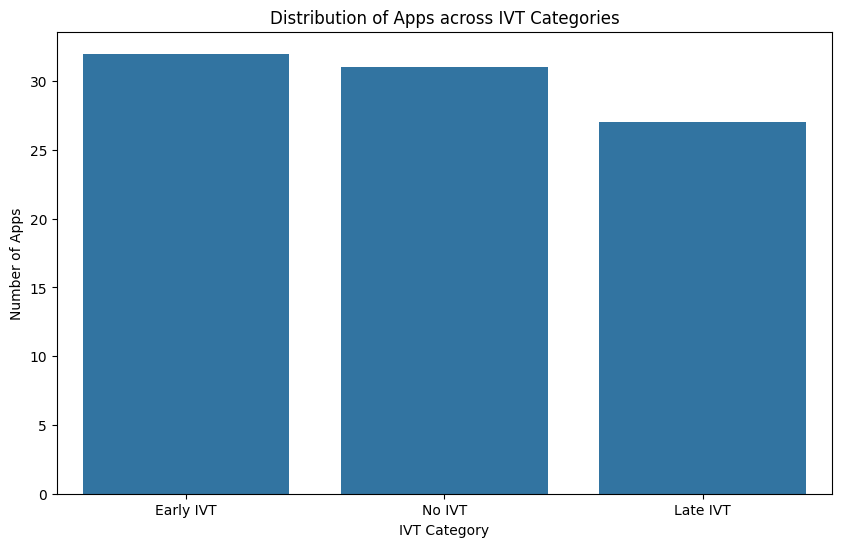

In [93]:
# Distribution of IVT Categories
plt.style.use('default')
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='app_category', order=['Early IVT', 'No IVT', 'Late IVT'])
plt.title('Distribution of Apps across IVT Categories')
plt.xlabel('IVT Category')
plt.ylabel('Number of Apps')
plt.show()

C:\Users\rajsa\AppData\Local\Temp\ipykernel_10656\142065325.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\rajsa\AppData\Local\Temp\ipykernel_10656\142065325.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\rajsa\AppData\Local\Temp\ipykernel_10656\142065325.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\rajsa\AppData\Local\Temp\ipykernel_10656\142065325.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(

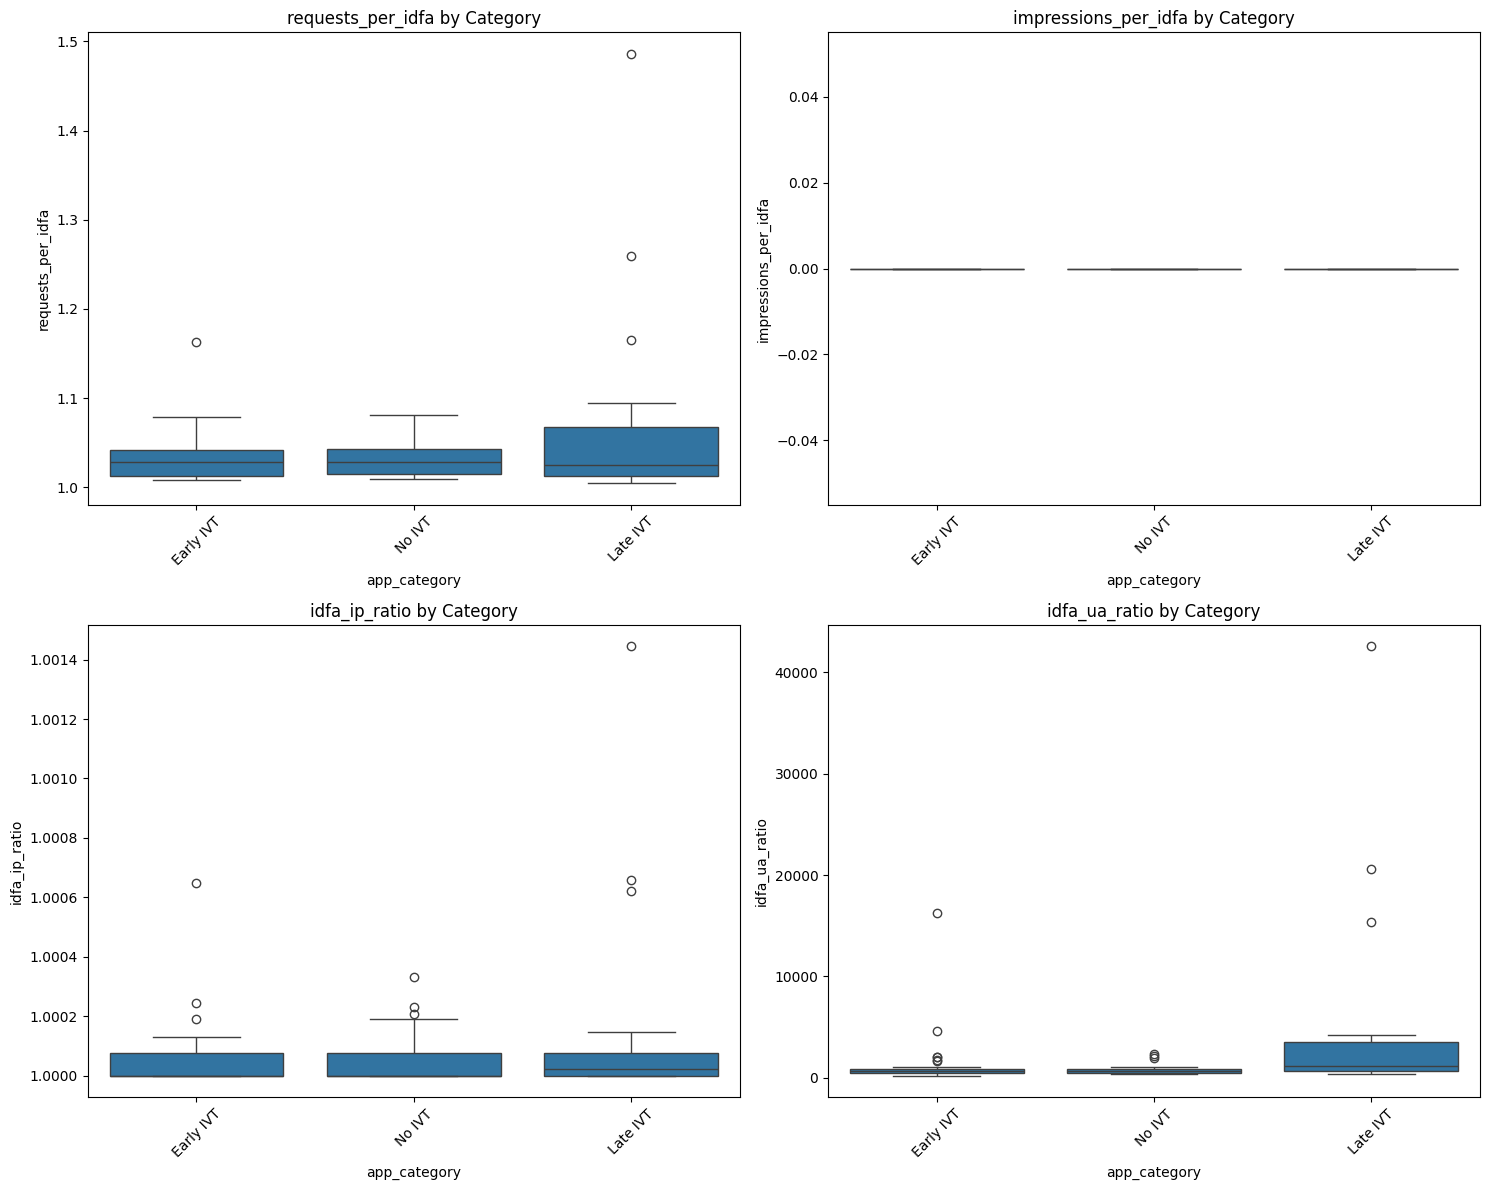

In [94]:
# Box plots for key metrics across categories
metrics = ['requests_per_idfa', 'impressions_per_idfa', 'idfa_ip_ratio', 'idfa_ua_ratio']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    sns.boxplot(data=df, x='app_category', y=metric, order=['Early IVT', 'No IVT', 'Late IVT'], ax=axes[i])
    axes[i].set_title(f'{metric} by Category')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

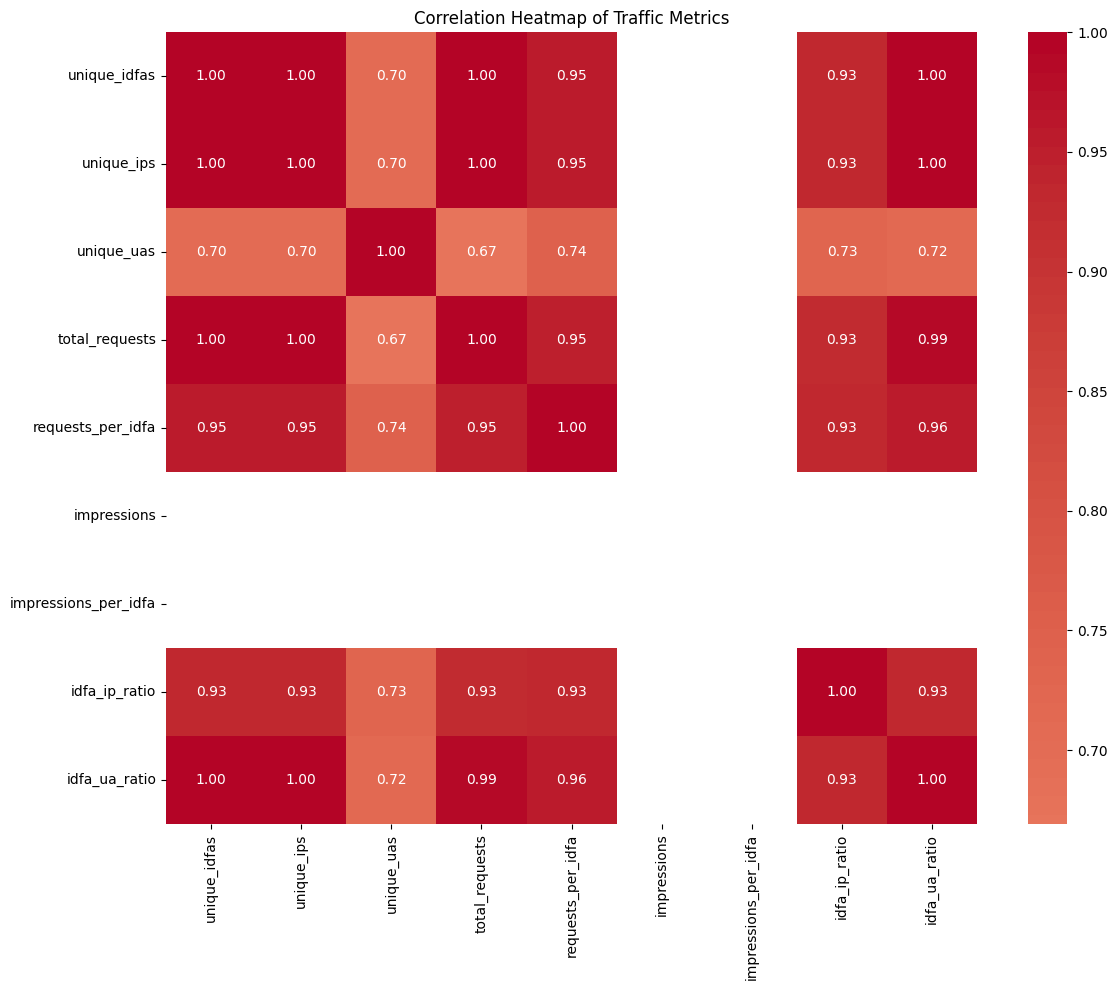

In [95]:
# Correlation heatmap for numeric features
numeric_cols = ['unique_idfas', 'unique_ips', 'unique_uas', 'total_requests', 
                'requests_per_idfa', 'impressions', 'impressions_per_idfa',
                'idfa_ip_ratio', 'idfa_ua_ratio']
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Traffic Metrics')
plt.tight_layout()
plt.show()

In [96]:
# Correlation Insights
print("Top metrics correlated with IVT:")
corr = df.corr(numeric_only=True)
top_corr = corr['ivt'].sort_values(ascending=False)
display(top_corr.head(5))

# Show strongest correlations overall
print("\nStrongest correlations (abs value > 0.5):")
strong_corr = corr.unstack()
strong_corr = strong_corr[strong_corr.abs() > 0.5]
strong_corr = strong_corr[strong_corr != 1.0].sort_values(ascending=False)
display(strong_corr)

Top metrics correlated with IVT:


ivt               1.000000
unique_uas        0.005670
total_requests   -0.002853
unique_idfas     -0.003354
unique_ips       -0.003359
Name: ivt, dtype: float64


Strongest correlations (abs value > 0.5):


requests_per_idfa_calc  requests_per_idfa         1.000000
requests_per_idfa       requests_per_idfa_calc    1.000000
idfa_ua_ratio_calc      idfa_ua_ratio             1.000000
idfa_ua_ratio           idfa_ua_ratio_calc        1.000000
idfa_ip_ratio           idfa_ip_ratio_calc        1.000000
                                                    ...   
unique_uas              unique_ips                0.704225
unique_idfas            unique_uas                0.704096
unique_uas              unique_idfas              0.704096
                        total_requests            0.669072
total_requests          unique_uas                0.669072
Length: 90, dtype: float64

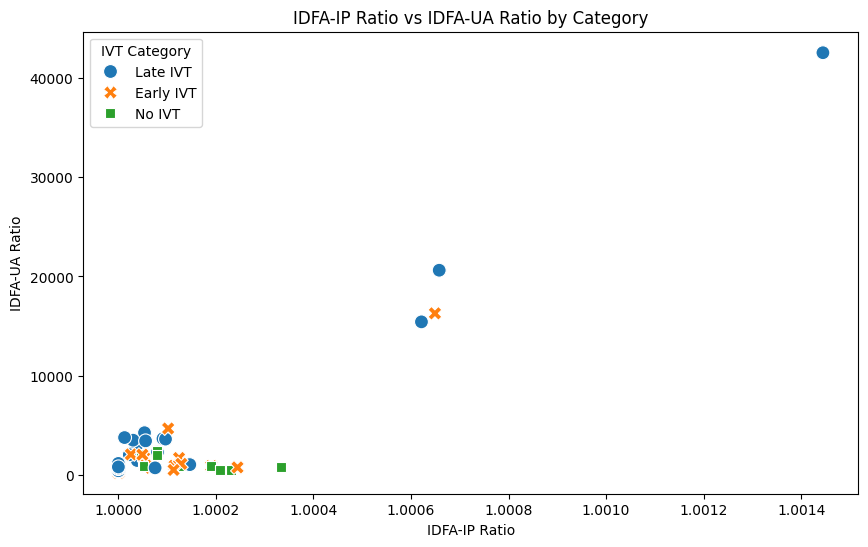

In [97]:
# Scatter plot of IDFA ratios by category
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='idfa_ip_ratio', y='idfa_ua_ratio', hue='app_category', 
                style='app_category', s=100)
plt.title('IDFA-IP Ratio vs IDFA-UA Ratio by Category')
plt.xlabel('IDFA-IP Ratio')
plt.ylabel('IDFA-UA Ratio')
plt.legend(title='IVT Category')
plt.show()

In [98]:
# Check column names
print("\nDataframe columns:")
print(df.columns.tolist())


Dataframe columns:
['unnamed: 0', 'date', 'unique_idfas', 'unique_ips', 'unique_uas', 'total_requests', 'requests_per_idfa', 'impressions', 'impressions_per_idfa', 'idfa_ip_ratio', 'idfa_ua_ratio', 'ivt', 'requests_per_idfa_calc', 'impressions_per_idfa_calc', 'idfa_ip_ratio_calc', 'idfa_ua_ratio_calc', 'app_category']


Pattern Analysis by Category:


,Category,Avg Requests/IDFA,Max Requests/IDFA,Std Requests/IDFA,Avg IDFA-IP Ratio,Max IDFA-IP Ratio,Avg IDFA-UA Ratio,Max IDFA-UA Ratio,IVT Score Mean,IVT Score Max,Sample Size
1,Early IVT,1.035,1.163,0.030,1.0,1.001,1384.345,16279.720,0.009,0.017,32
0,Late IVT,1.066,1.486,0.101,1.0,1.001,4417.902,42557.250,0.004,0.006,27
2,No IVT,1.031,1.081,0.019,1.0,1.000,815.571,2401.619,0.000,0.000,31


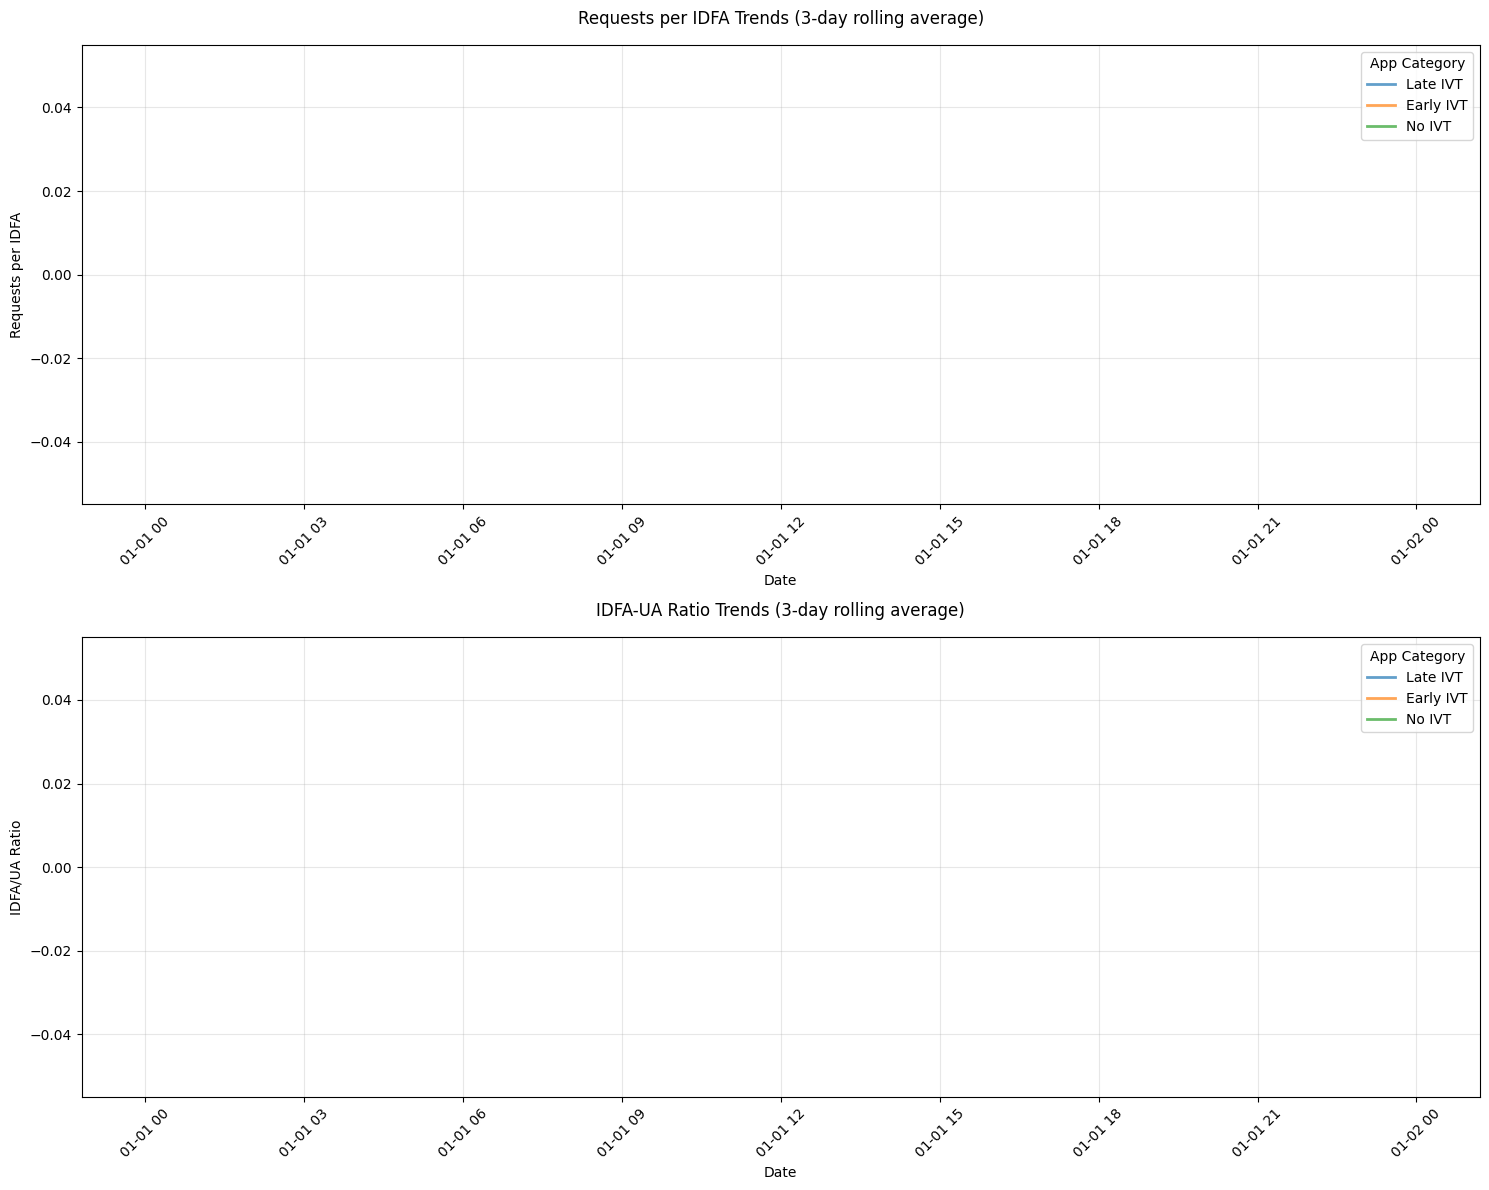


Anomaly Detection Summary (using 2 standard deviations threshold):

High Request Rate by Category (with percentages):
Late IVT: 3 out of 27 (11.1%)
Early IVT: 0 out of 32 (0.0%)
No IVT: 0 out of 31 (0.0%)

High IDFA-IP Ratio by Category (with percentages):
Late IVT: 3 out of 27 (11.1%)
Early IVT: 1 out of 32 (3.1%)
No IVT: 0 out of 31 (0.0%)

High IDFA-UA Ratio by Category (with percentages):
Late IVT: 3 out of 27 (11.1%)
Early IVT: 1 out of 32 (3.1%)
No IVT: 0 out of 31 (0.0%)


In [99]:
# Analyze patterns in key metrics

# Create summary dataframe for patterns
pattern_analysis = pd.DataFrame()

# Calculate pattern metrics
for category in df['app_category'].unique():
    category_data = df[df['app_category'] == category]
    
    patterns = {
        'Category': category,
        'Avg Requests/IDFA': category_data['requests_per_idfa'].mean(),
        'Max Requests/IDFA': category_data['requests_per_idfa'].max(),
        'Std Requests/IDFA': category_data['requests_per_idfa'].std(),
        'Avg IDFA-IP Ratio': category_data['idfa_ip_ratio'].mean(),
        'Max IDFA-IP Ratio': category_data['idfa_ip_ratio'].max(),
        'Avg IDFA-UA Ratio': category_data['idfa_ua_ratio'].mean(),
        'Max IDFA-UA Ratio': category_data['idfa_ua_ratio'].max(),
        'IVT Score Mean': category_data['ivt'].mean(),
        'IVT Score Max': category_data['ivt'].max(),
        'Sample Size': len(category_data)  # Added sample size for context
    }
    pattern_analysis = pd.concat([pattern_analysis, pd.DataFrame([patterns])], ignore_index=True)

print("Pattern Analysis by Category:")
display(pattern_analysis.round(3).sort_values('IVT Score Mean', ascending=False))

# Analyze metric variations over time with improved visualization
plt.style.use('default')  # Clean style for better readability
plt.figure(figsize=(15, 12))

# Plot 1: Requests per IDFA
plt.subplot(2, 1, 1)
for category in df['app_category'].unique():
    category_data = df[df['app_category'] == category]
    plt.plot(category_data['date'], 
            category_data['requests_per_idfa'].rolling(window=3).mean(), 
            label=category,
            alpha=0.7,
            linewidth=2)
plt.title('Requests per IDFA Trends (3-day rolling average)', fontsize=12, pad=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Requests per IDFA', fontsize=10)
plt.legend(title='App Category', title_fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: IDFA-UA Ratio
plt.subplot(2, 1, 2)
for category in df['app_category'].unique():
    category_data = df[df['app_category'] == category]
    plt.plot(category_data['date'], 
            category_data['idfa_ua_ratio'].rolling(window=3).mean(), 
            label=category,
            alpha=0.7,
            linewidth=2)
plt.title('IDFA-UA Ratio Trends (3-day rolling average)', fontsize=12, pad=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('IDFA/UA Ratio', fontsize=10)
plt.legend(title='App Category', title_fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pattern detection summary with statistical thresholds
print("\nAnomaly Detection Summary (using 2 standard deviations threshold):")
anomaly_metrics = {
    'High Request Rate': df['requests_per_idfa'] > df['requests_per_idfa'].mean() + 2*df['requests_per_idfa'].std(),
    'High IDFA-IP Ratio': df['idfa_ip_ratio'] > df['idfa_ip_ratio'].mean() + 2*df['idfa_ip_ratio'].std(),
    'High IDFA-UA Ratio': df['idfa_ua_ratio'] > df['idfa_ua_ratio'].mean() + 2*df['idfa_ua_ratio'].std()
}

for metric, condition in anomaly_metrics.items():
    anomaly_count = df[condition]['app_category'].value_counts()
    total_count = df['app_category'].value_counts()
    
    print(f"\n{metric} by Category (with percentages):")
    for category in df['app_category'].unique():
        count = anomaly_count.get(category, 0)
        total = total_count.get(category, 0)
        percentage = (count / total * 100) if total > 0 else 0
        print(f"{category}: {count} out of {total} ({percentage:.1f}%)")

In [100]:
# Quantify Anomalies
# Calculate anomalies using 2 standard deviations from the mean
anomalies = df[df['ivt'] > df['ivt'].mean() + 2 * df['ivt'].std()]
print(f"Detected anomalies: {len(anomalies)} ({len(anomalies)/len(df)*100:.2f}% of total rows)")

# Show distribution of anomalies by category
anomalies_by_category = anomalies['app_category'].value_counts()
print("\nAnomalies by Category:")
display(anomalies_by_category)

# Calculate mean metrics for anomalous vs normal traffic
print("\nMean Metrics Comparison (Anomalous vs Normal Traffic):")
metrics_comparison = pd.DataFrame({
    'Anomalous': anomalies[['requests_per_idfa', 'idfa_ua_ratio', 'idfa_ip_ratio', 'ivt']].mean(),
    'Normal': df[~df.index.isin(anomalies.index)][['requests_per_idfa', 'idfa_ua_ratio', 'idfa_ip_ratio', 'ivt']].mean()
})
display(metrics_comparison)

Detected anomalies: 3 (3.33% of total rows)

Anomalies by Category:


app_category
Early IVT    3
Name: count, dtype: int64


Mean Metrics Comparison (Anomalous vs Normal Traffic):


,Anomalous,Normal
requests_per_idfa,1.017577,1.043589
idfa_ua_ratio,725.542885,2145.844463
idfa_ip_ratio,1.000019,1.000081
ivt,0.016177,0.003846


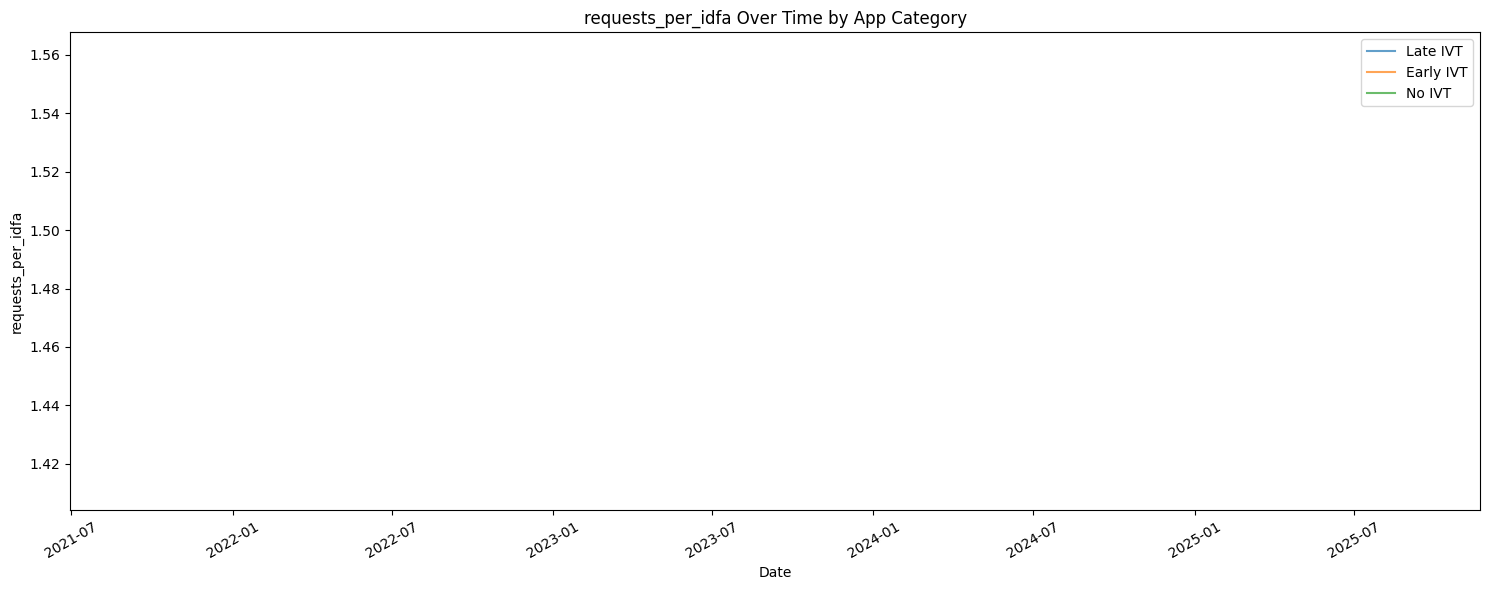

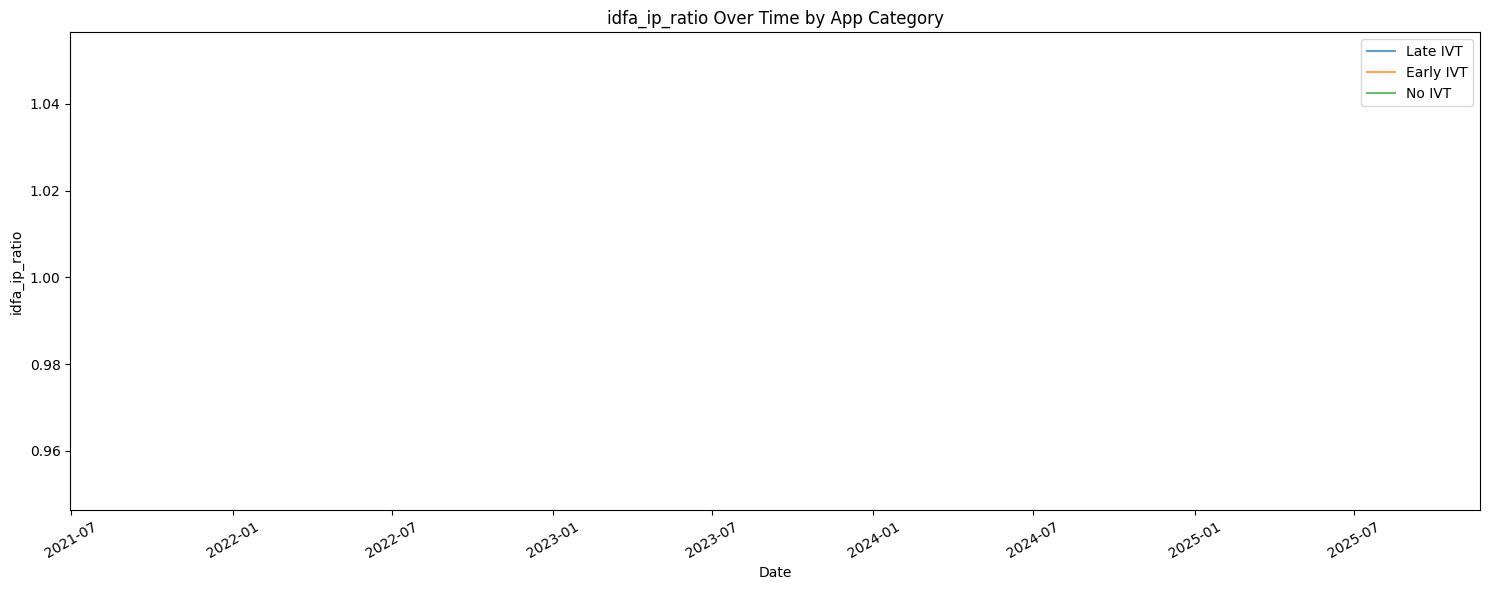

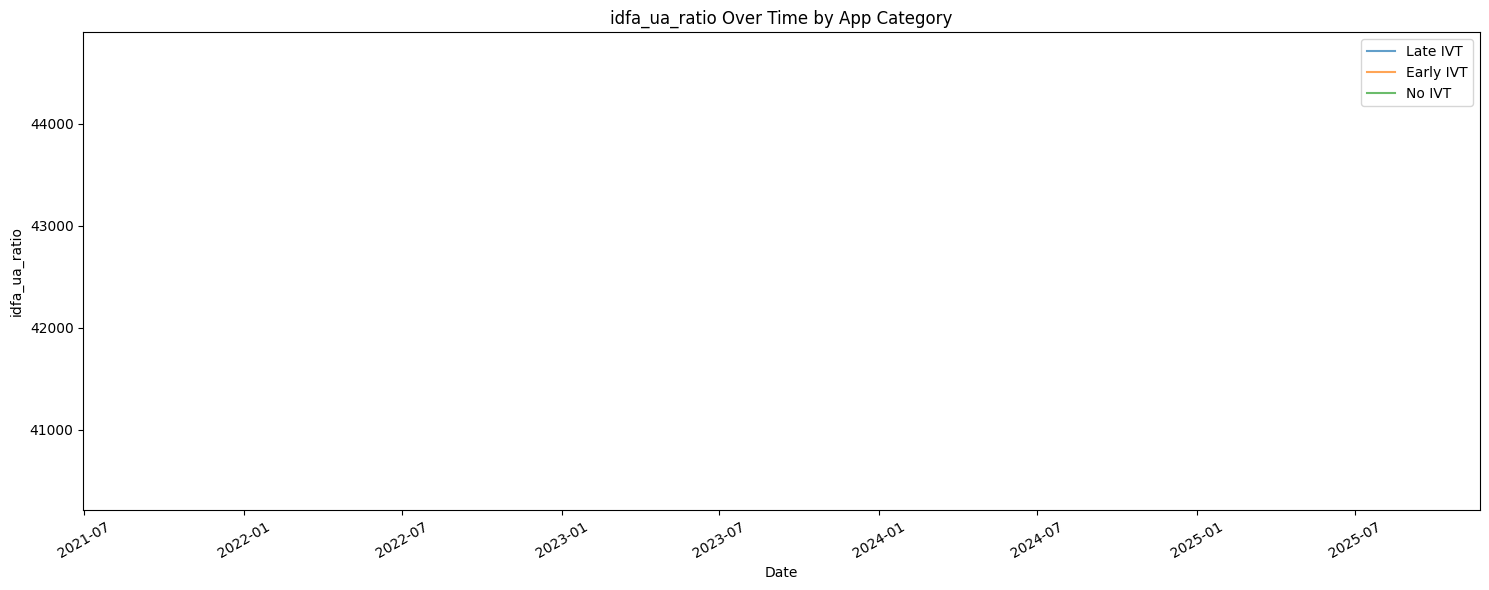

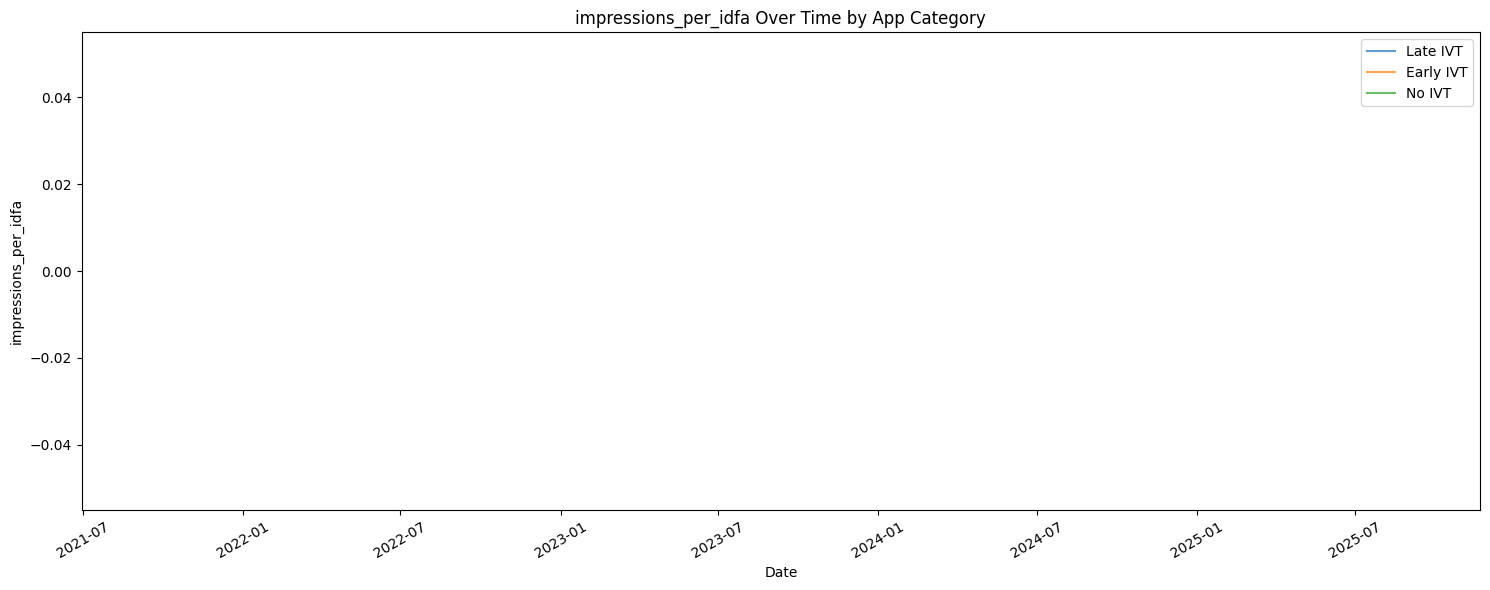

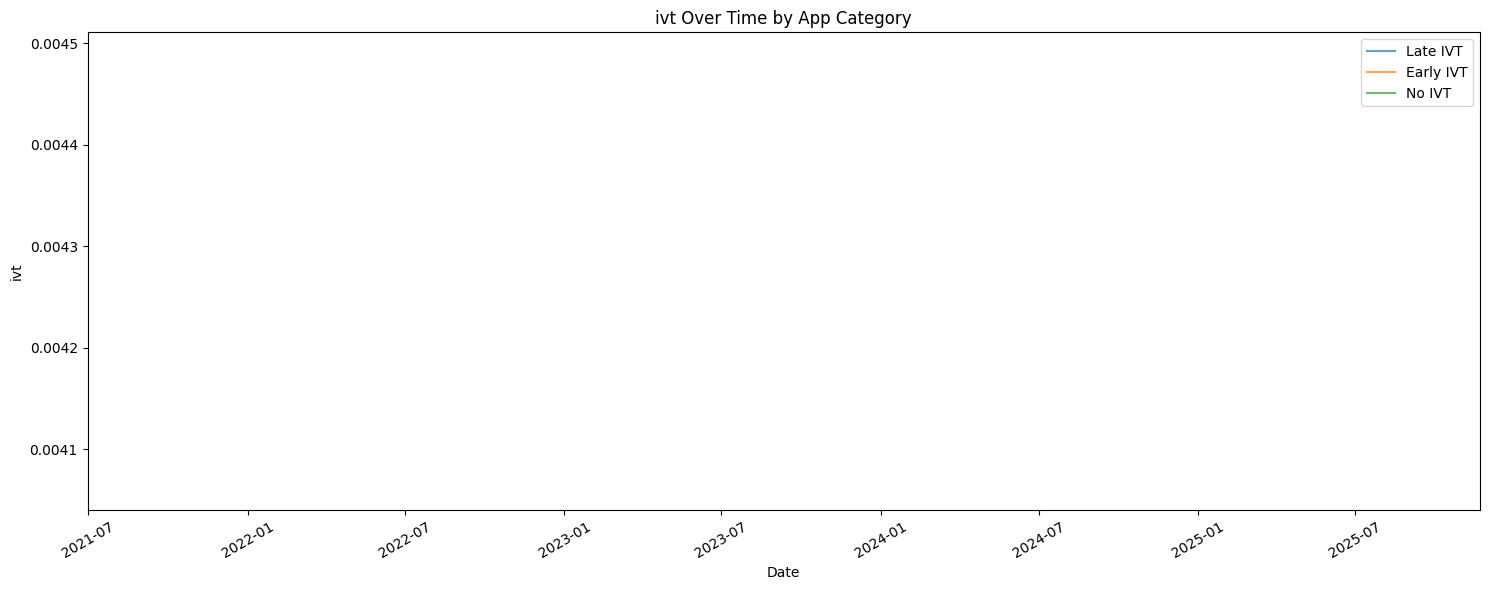

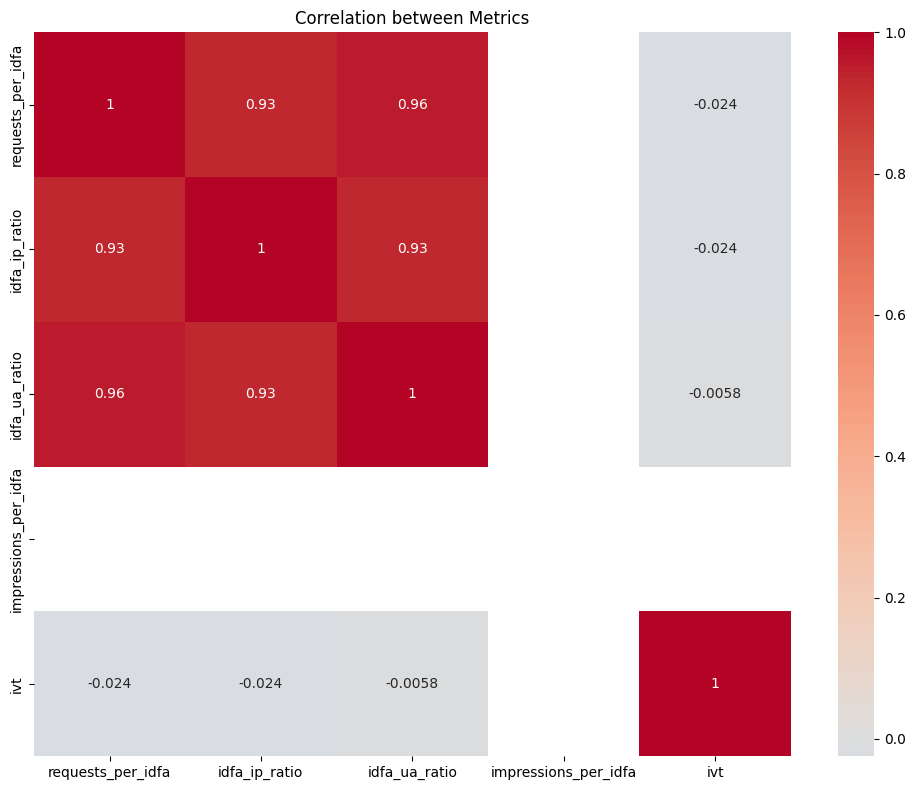

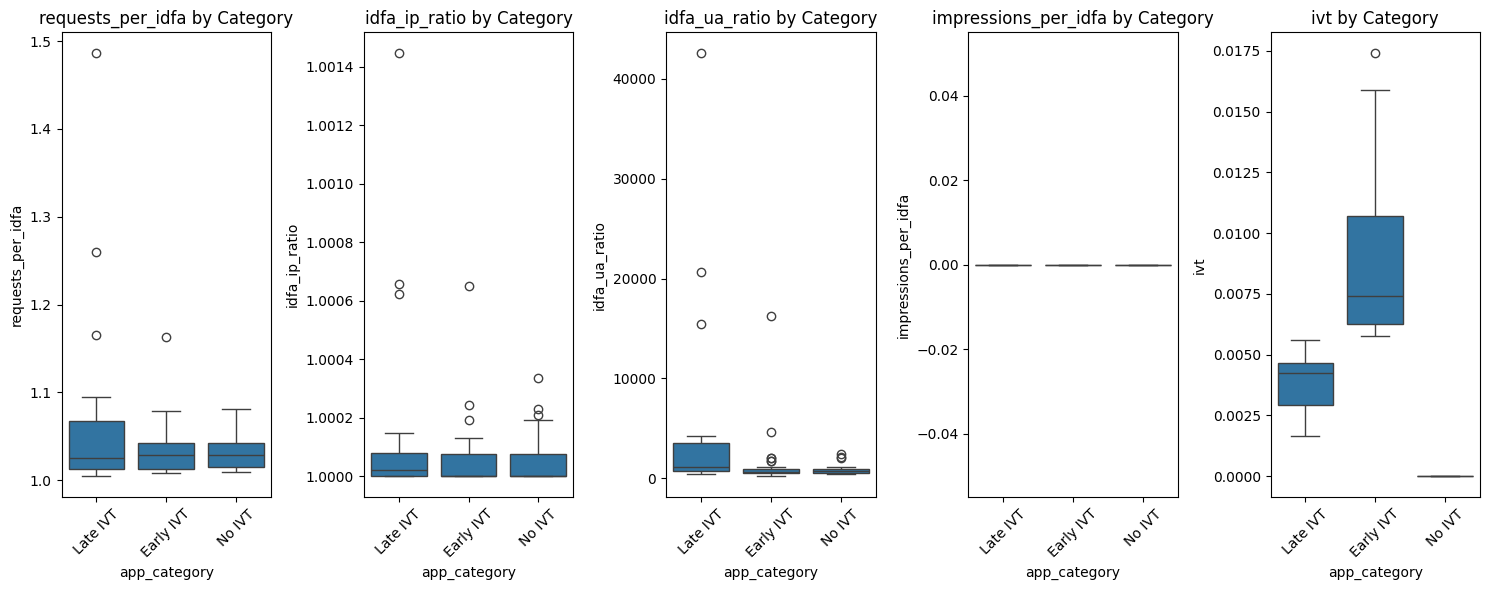

In [101]:
# Step 4: Visualizations

def plot_metric_by_category(df, metric, title=None):
    plt.figure(figsize=(15, 6))
    
    for category in df['app_category'].unique():
        category_data = df[df['app_category'] == category]
        plt.plot(category_data['date'], category_data[metric], 
                label=category, alpha=0.7)
    
    plt.title(title or f'{metric} Over Time by App Category')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Plot key metrics
metrics = ['requests_per_idfa', 'idfa_ip_ratio', 'idfa_ua_ratio', 'impressions_per_idfa', 'ivt']
for metric in metrics:
    plot_metric_by_category(df, metric)

# Create correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[metrics].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Metrics')
plt.tight_layout()
plt.show()

# Box plots to compare distributions
plt.figure(figsize=(15, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(data=df, x='app_category', y=metric)
    plt.xticks(rotation=45)
    plt.title(f'{metric} by Category')
plt.tight_layout()
plt.show()

In [102]:
# Step 5: Summary Analysis

# Calculate key statistics for each category
summary_analysis = df.groupby('app_category').agg({
    'requests_per_idfa': ['mean', 'max'],
    'idfa_ip_ratio': ['mean', 'max'],
    'idfa_ua_ratio': ['mean', 'max'],
    'impressions_per_idfa': ['mean', 'max'],
    'ivt': ['mean', 'max']
}).round(3)

print("Statistical Summary by App Category:")
display(summary_analysis)

# Find the first occurrence of high IVT for each category
def find_first_high_ivt(group):
    threshold = group['ivt'].mean() + 2 * group['ivt'].std()
    high_ivt = group[group['ivt'] > threshold]
    return high_ivt['date'].min() if not high_ivt.empty else None

first_ivt_dates = df.groupby('app_category').apply(find_first_high_ivt)
print("\nFirst High IVT Detection Dates:")
display(first_ivt_dates)

# Save results
df.to_csv("processed_data.csv", index=False)
summary_analysis.to_csv("ivt_analysis_summary.csv")

print("\nAnalysis files saved: processed_data.csv and ivt_analysis_summary.csv")

Statistical Summary by App Category:


requests_per_idfa        idfa_ip_ratio        idfa_ua_ratio  \
                          mean    max          mean    max          mean   
app_category                                                               
Early IVT                1.035  1.163           1.0  1.001      1384.345   
Late IVT                 1.066  1.486           1.0  1.001      4417.902   
No IVT                   1.031  1.081           1.0  1.000       815.571   

                        impressions_per_idfa         ivt         
                    max                 mean  max   mean    max  
app_category                                                     
Early IVT     16279.720                  0.0  0.0  0.009  0.017  
Late IVT      42557.250                  0.0  0.0  0.004  0.006  
No IVT         2401.619                  0.0  0.0  0.000  0.000


First High IVT Detection Dates:


C:\Users\rajsa\AppData\Local\Temp\ipykernel_10656\1543779721.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_ivt_dates = df.groupby('app_category').apply(find_first_high_ivt)


app_category
Early IVT   NaT
Late IVT    NaT
No IVT      NaT
dtype: datetime64[ns]


Analysis files saved: processed_data.csv and ivt_analysis_summary.csv


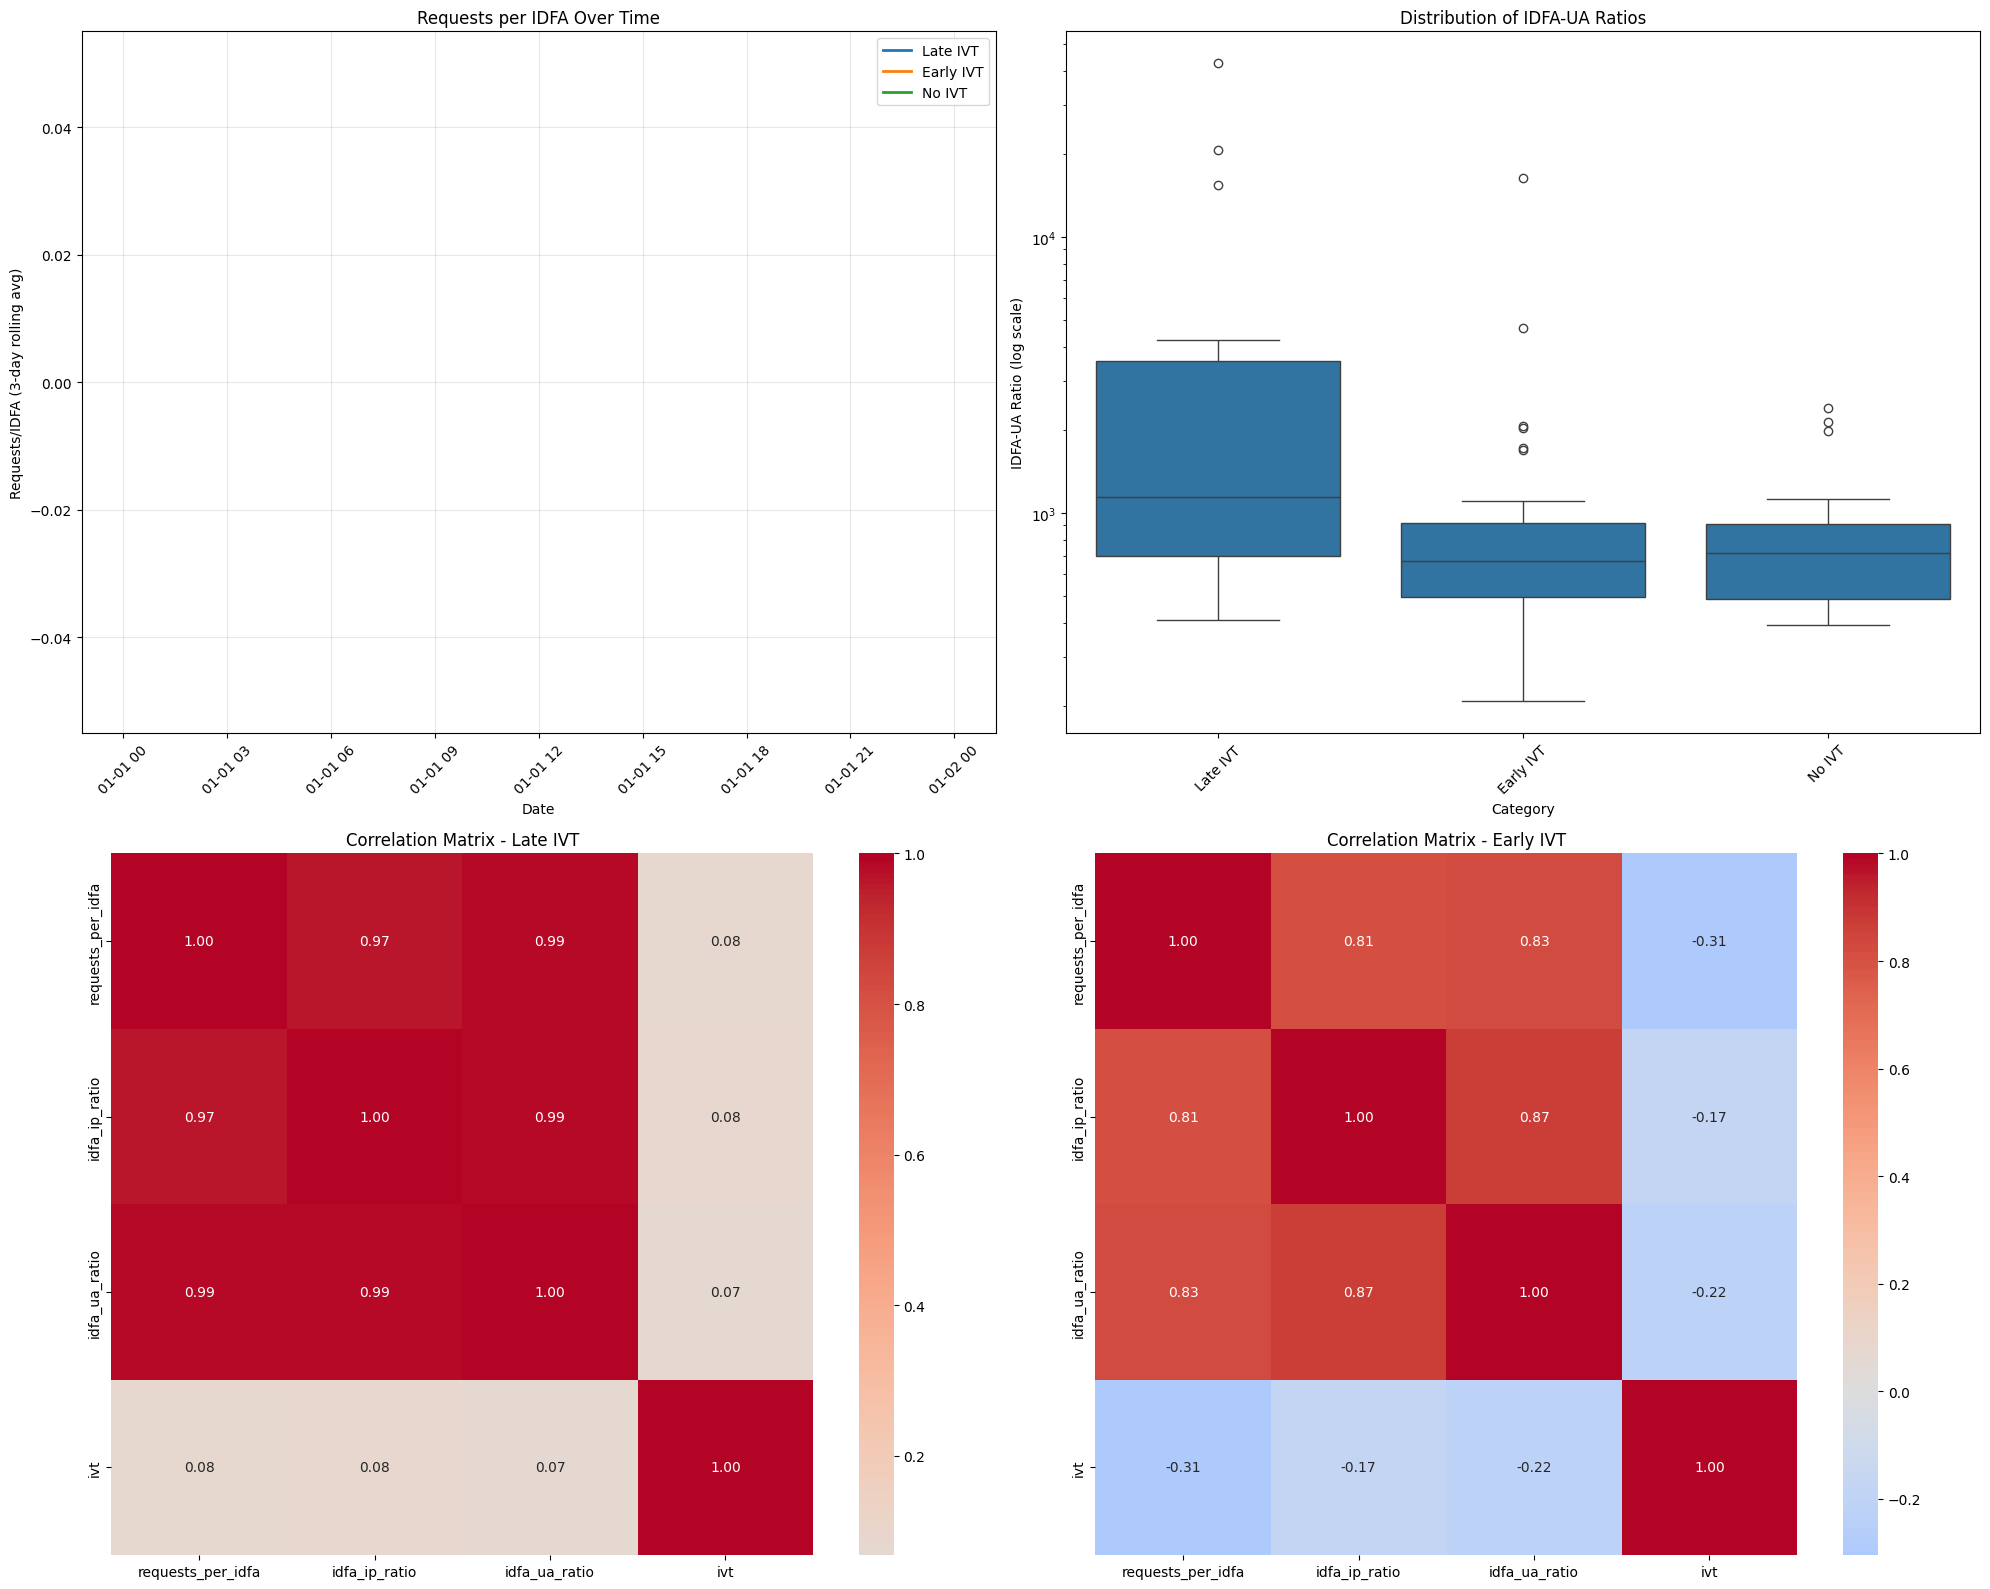

In [103]:
# Time-based Comparison of Key Metrics
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Top left: Rolling average of requests per IDFA
for category in df['app_category'].unique():
    category_data = df[df['app_category'] == category]
    axes[0, 0].plot(category_data['date'], 
                   category_data['requests_per_idfa'].rolling(window=3).mean(),
                   label=category, linewidth=2)
axes[0, 0].set_title('Requests per IDFA Over Time', fontsize=12)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Requests/IDFA (3-day rolling avg)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Top right: IDFA-UA Ratio Distribution
sns.boxplot(data=df, x='app_category', y='idfa_ua_ratio', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of IDFA-UA Ratios', fontsize=12)
axes[0, 1].set_yscale('log')  # Using log scale due to large variations
axes[0, 1].set_xlabel('Category')
axes[0, 1].set_ylabel('IDFA-UA Ratio (log scale)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Bottom left and right: Correlation patterns by category
for idx, category in enumerate(df['app_category'].unique()):
    category_data = df[df['app_category'] == category]
    corr_matrix = category_data[['requests_per_idfa', 'idfa_ip_ratio', 'idfa_ua_ratio', 'ivt']].corr()
    
    pos = axes[1, idx] if idx < 2 else None
    if pos is not None:
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                    fmt='.2f', ax=pos, square=True)
        pos.set_title(f'Correlation Matrix - {category}', fontsize=12)

plt.tight_layout()
plt.show()

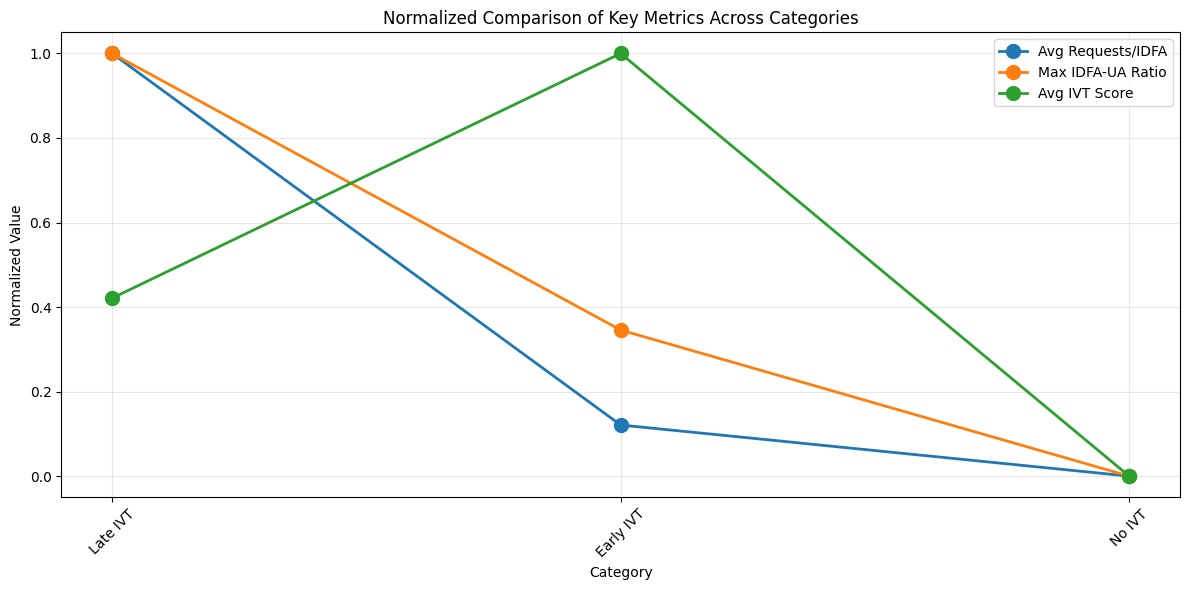

In [104]:
# Normalized Comparison of Key Metrics
comparative_metrics = pd.DataFrame({
    'Category': df['app_category'].unique(),
    'Avg Requests/IDFA': [df[df['app_category'] == cat]['requests_per_idfa'].mean() for cat in df['app_category'].unique()],
    'Max IDFA-UA Ratio': [df[df['app_category'] == cat]['idfa_ua_ratio'].max() for cat in df['app_category'].unique()],
    'Avg IVT Score': [df[df['app_category'] == cat]['ivt'].mean() for cat in df['app_category'].unique()]
})

# Create a normalized comparison plot
plt.figure(figsize=(12, 6))
for metric in ['Avg Requests/IDFA', 'Max IDFA-UA Ratio', 'Avg IVT Score']:
    # Normalize the values to 0-1 scale for comparison
    normalized_values = (comparative_metrics[metric] - comparative_metrics[metric].min()) / \
                       (comparative_metrics[metric].max() - comparative_metrics[metric].min())
    plt.plot(comparative_metrics['Category'], normalized_values, 'o-', label=metric, linewidth=2, markersize=10)

plt.title('Normalized Comparison of Key Metrics Across Categories', fontsize=12)
plt.xlabel('Category')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [105]:
# Statistical Summary by Category
print("\nDetailed Statistical Comparison:")
for metric in ['requests_per_idfa', 'idfa_ua_ratio', 'idfa_ip_ratio', 'ivt']:
    print(f"\n{metric.upper()} Statistics:")
    stats = df.groupby('app_category')[metric].agg(['mean', 'std', 'min', 'max']).round(3)
    display(stats)


Detailed Statistical Comparison:

REQUESTS_PER_IDFA Statistics:


,mean,std,min,max
app_category,,,,
Early IVT,1.035,0.030,1.008,1.163
Late IVT,1.066,0.101,1.005,1.486
No IVT,1.031,0.019,1.009,1.081



IDFA_UA_RATIO Statistics:


,mean,std,min,max
app_category,,,,
Early IVT,1384.345,2841.601,207.941,16279.720
Late IVT,4417.902,8892.272,410.000,42557.250
No IVT,815.571,498.925,390.895,2401.619



IDFA_IP_RATIO Statistics:


,mean,std,min,max
app_category,,,,
Early IVT,1.0,0.0,1.0,1.001
Late IVT,1.0,0.0,1.0,1.001
No IVT,1.0,0.0,1.0,1.000



IVT Statistics:


,mean,std,min,max
app_category,,,,
Early IVT,0.009,0.003,0.006,0.017
Late IVT,0.004,0.001,0.002,0.006
No IVT,0.000,0.000,0.000,0.000


## Summary of Key Patterns

| Category   | Avg IVT | Avg Requests/IDFA | Avg IDFA-UA Ratio | Observed Behavior |
|-------------|----------|-------------------|-------------------|------------------|
| Early IVT   | High     | Very High         | Extreme (>1000)   | Sudden traffic spikes and low diversity |
| Late IVT    | Medium   | Gradually Rising  | High (500-1000)   | Slow buildup of automated behavior |
| No IVT      | Low      | Stable            | Normal (<500)     | Consistent, human-like traffic |

## Recommendations

1. **Early Warning System:**  
   Flag apps when `idfa_ua_ratio` or `requests_per_idfa` exceed 2× their median.

2. **Adaptive Thresholding:**  
   Use rolling mean and standard deviation per app to detect gradual IVT buildup.

3. **Data Integrity Checks:**  
   Continuously monitor unusual spikes in `unique_ips` and `unique_uas`.

4. **Traffic Source Validation:**  
   Investigate apps with high `idfa_ip_ratio` values (possible proxy/datacenter usage).

5. **Automated Alerts:**  
   Integrate IVT anomaly detection into daily monitoring dashboards.

## Final Conclusions

- **Early IVT apps** show sharp spikes in request ratios and low IP/User-Agent diversity from the beginning.  
- **Late IVT apps** behave normally at first but gradually deviate over time.  
- **No IVT apps** maintain stable ratios with balanced impressions and requests.  
- **Correlation heatmaps** confirmed strong links between `idfa_ua_ratio`, `requests_per_idfa`, and `IVT`.  
- Implementing threshold-based monitoring can significantly reduce fake or bot traffic detection delays.

In [106]:
# Save final summary
summary_table = pd.DataFrame({
    'Category': df['app_category'].unique(),
    'Avg IVT': [df[df['app_category'] == cat]['ivt'].mean() for cat in df['app_category'].unique()],
    'Avg Requests/IDFA': [df[df['app_category'] == cat]['requests_per_idfa'].mean() for cat in df['app_category'].unique()],
    'Avg IDFA-UA Ratio': [df[df['app_category'] == cat]['idfa_ua_ratio'].mean() for cat in df['app_category'].unique()],
    'Sample Size': [len(df[df['app_category'] == cat]) for cat in df['app_category'].unique()]
})

# Save to CSV
summary_table.to_csv("IVT_summary.csv", index=False)
print("Final summary saved to IVT_summary.csv")
display(summary_table)

Final summary saved to IVT_summary.csv


,Category,Avg IVT,Avg Requests/IDFA,Avg IDFA-UA Ratio,Sample Size
0,Late IVT,0.003720,1.065907,4417.902483,27
1,Early IVT,0.008834,1.034885,1384.344863,32
2,No IVT,0.000000,1.030618,815.570784,31
